In [1]:
%matplotlib inline
from __future__ import print_function, division
import sys, os
import json
import math
import itertools, collections
import datetime as dt

In [2]:
import geopandas as gp
import pandas as pd

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("poster")
#sns.set_context("talk", font_scale=1.4)

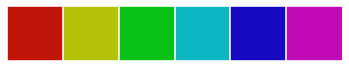

In [4]:
current_palette = sns.color_palette(sns.hls_palette(6, l=.4, s=.9))
sns.set_palette(current_palette)
sns.palplot(current_palette)
palette = itertools.cycle(sns.color_palette())

We use Alaska Albers shapefiles all around to be able to measure distances in metres. The WGS84 shapefiles from AICC and the Forest Service Active Fire Maps web portal were converted using GDAL: 

`ogr2ogr -f "ESRI Shapefile" outfile_AKAlbers.shp infile.shp -s_srs EPSG:4326 -t_SRS EPSG:3338` 

### Data loading - fire events as per management agencies & remotely sensed hotspots

Fire GIS data from AICC. (*NOTE:* The AK Albers Shapefile for fire locations was generated not directly from the WGS84 AICC shapefile. The latter was found to be somewhat corrupted with fields out of date. I first transformed it to JSON-WGS84 and then generated the AK Albers Shapefile from the JSON. Data thus generated looks consistent.) These have been pre-processed and joined against fire perimeters. 

In [5]:
datadir = "/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/10_intermediate_products/"
fireperimshp = "2016cleanedFirePerimsWithFirepoints20170417.shp"

Active fire hotspots from FIRMS, also pre-processed:

In [6]:
mod14shp = "2016MOD14_Perims_AKAlbers_5km.shp"
viirsIshp = "2016VIIRSI_Perims_AKAlbers_5km.shp"

In [7]:
fireperimDF = gp.GeoDataFrame.from_file(os.path.join(datadir, fireperimshp))
mod14DF = gp.GeoDataFrame.from_file(os.path.join(datadir, mod14shp))
viirsIDF = gp.GeoDataFrame.from_file(os.path.join(datadir, viirsIshp))

We keep a list of columns for printing out data. 

In [8]:
maincols = [u'FireName', u'CalcAcres', u'PrimFuel', u'MgmOption', u'InitBehave', 
            u'PerimDate', u'DiscDate', u'CntrlDate', u'OutDate']

In [9]:
numperims = len(fireperimDF)

In [10]:
print("Total number of fire perimeters: {}".format(numperims))
print("Number of fire perimeters with AFS ID: {}".format(numperims - sum(fireperimDF['AFSFire#'].isnull())))
print("Number of fire perimeters with DOF ID: {}".format(numperims - sum(fireperimDF['DOFFire#'].isnull())))
print("Number of fire perimeters with USFS ID: {}".format(numperims - sum(fireperimDF['USFSFire#'].isnull())))


Total number of fire perimeters: 155
Number of fire perimeters with AFS ID: 138
Number of fire perimeters with DOF ID: 103
Number of fire perimeters with USFS ID: 24


In [11]:
cleanedfireperimDF = fireperimDF

In [12]:
cleanedfireperimDF.columns

Index([  u'AFSFire#',       u'AREA',   u'AddFire#', u'AgencyAcre',
           u'Aspect',  u'CalcAcres',  u'CntrlDate',   u'Comments',
          u'Complex',   u'DOFFire#',   u'DiscDate',   u'DiscSize',
         u'EditDate',  u'Elevation',   u'EstAcres',    u'EstCost',
           u'FIREID', u'FalseAlarm',      u'Final',   u'FireName',
         u'FireYear',   u'GenCause',     u'IADate',     u'IASize',
       u'InitBehave', u'LATESTPERI',        u'LEN',   u'Latitude',
        u'Longitude', u'MOD14Acoun', u'MOD14Tcoun', u'MOD14count',
          u'MapName',     u'Method',      u'MgmID',   u'MgmOffId',
        u'MgmOption',  u'NearestWX',  u'OriginOwn', u'OriginUnit',
          u'OutDate',  u'PerimDate',  u'PerimTime', u'Prescribed',
         u'PrimFuel',    u'Record#',      u'Slope',     u'Source',
        u'SpecCause',   u'SrcClass',  u'SrcMethod',  u'StrBurned',
        u'StrThreat',  u'USFSFire#', u'VIIRSIcoun',  u'cleanedID',
         u'geometry'],
      dtype='object')

### Inspecting the cleaned perimeter dataset, and last adjustments

Here is the reason I kept these columns. I'll change the case of the management options... 

In [13]:
cleanedfireperimDF['PrimFuel'].value_counts()

Black Spruce                   88
Tundra                         17
Mixed (Hardwoods/Softwoods)    11
Grass                          10
Other                           9
Dead White Spruce               6
Tussock                         5
Hardwoods                       4
Unknown                         3
Mixed Trees                     1
Brush                           1
Name: PrimFuel, dtype: int64

In [14]:
cleanedfireperimDF['InitBehave'].value_counts()

Creeping      53
Rank 1        38
Running       22
Smoldering    12
Rank 3        11
Rank 2        10
Crowning       3
Rank 4         2
Unknown        1
Out            1
Rank 5         1
Name: InitBehave, dtype: int64

We also need to ensure spelling of the properties is normalised:

In [15]:
cleanedfireperimDF['MgmOption'].value_counts()

Limited     99
Full        29
Modified    24
Critical     3
Name: MgmOption, dtype: int64

In [16]:
cleanedfireperimDF['GenCause'].value_counts()

Lightning    133
Human         22
Name: GenCause, dtype: int64

In [17]:
cleanedfireperimDF.sort_values(by="CalcAcres", ascending=False).head(n=10)

,AFSFire#,AREA,AddFire#,AgencyAcre,Aspect,CalcAcres,CntrlDate,Comments,Complex,DOFFire#,...,Source,SpecCause,SrcClass,SrcMethod,StrBurned,StrThreat,USFSFire#,VIIRSIcoun,cleanedID,geometry
32,KD94,0.047966,None,0.0,Flat,58565.3,2016-07-12,Digitized from Landsat 8 image collected 8/16/16,None,631399,...,Digitized,Lightning,B - Within 90 Meters,Image,0,0,None,1323,KD94,"POLYGON ((1221.001382690641 1847941.319830814,..."
71,KB69,0.046233,None,0.0,Flat,58137.8,2016-09-29,Portions of the perimeter updated using Landsa...,None,632325,...,Digitized,Lightning,None,Image,0,0,PDKB69,993,KB69,POLYGON ((-73643.23357015298 1779075.461607415...
145,KB76,0.043177,None,0.0,Flat,52334.7,2016-09-22,Digitized from Landsat 8 image collected 8/16/16,None,631337,...,Digitized,Lightning,B - Within 90 Meters,Image,0,0,None,1007,KB76,"POLYGON ((11909.08875179134 1876762.4853593, 1..."
74,J9R3,0.033728,None,0.0,South West,44539.9,2016-09-22,Digitized from Landsat 8 image collected 8/16/16,None,632226,...,Digitized,Lightning,B - Within 90 Meters,Image,0,1,PDJ9R3,152,J9R3,"POLYGON ((39182.21833742519 1616190.144272745,..."
12,KB51,0.030754,None,0.0,Flat,36751.9,2016-09-22,Digitized using Landsat 8 image collected 8/16/16,None,631320,...,Digitized,Lightning,B - Within 90 Meters,Image,0,3,PDKB51,983,KB51,"POLYGON ((63177.72295097367 1912038.850102146,..."
123,KC93,0.028833,None,0.0,Flat,34590.8,2016-09-29,Original perimeter updated using Landsat 8 fro...,None,631386,...,Digitized,Lightning,None,Image,0,0,PDKC93,596,KC93,(POLYGON ((-71595.44157561524 1907172.09862933...
43,J9TV,0.014794,None,0.0,North,21304.5,2016-08-21,Digitized from Landsat 8 image collected 6/27,None,632235,...,Digitized,Lightning,B - Within 90 Meters,Image,0,0,PDJ9TV,329,J9TV,POLYGON ((-378851.4657811324 1366614.111643162...
58,KF4K,0.013345,None,0.0,NW,19719.0,None,Perimeter submitted by NPS.,None,614521,...,GPS,Lightning,None,Helicopter,0,0,PNKF4K,1240,KF4K,"POLYGON ((571351.8192627283 1304384.556262721,..."
70,KB7C,0.011959,None,0.0,Flat,14864.2,2016-09-29,Portions of the perimeter updated using Landsa...,None,631326,...,Digitized,Lightning,None,Image,0,0,PDKB7C,232,KB7C,POLYGON ((-76461.19148721524 1800471.634490524...
66,KF09,0.008471,None,0.0,East,10912.8,2016-08-21,Perimeter updated using Landsat 8 imagery.,None,None,...,Digitized,Lightning,None,Image,0,0,None,203,KF09,"POLYGON ((-200773.0053468661 1706191.38626414,..."


In [18]:
cleanedfireperimDF['OutDate'].max()

u'2016-12-31'

In [19]:
cleanedfireperimDF['DiscDate'].min()

u'2016-04-07'

In [20]:
cleanedfireperimDF['DiscDate'].max()

u'2016-10-15'

In [21]:
viirsIDF.shape

(11091, 19)

In [22]:
viirsIDF['ACQ_DATE'].min()

u'2016-01-11'

In [23]:
viirsIDF['ACQ_DATE'].max()

u'2016-10-31'

In [24]:
viirsIDF['LONGITUDE'].max()

-141.08199999999999

In [25]:
cleanedfireperimDF['Comments']

0          Digitized from Landsat 8 image collected 6/21
1                    Photo rectification; SWS zone staff
2                        Perimeter submitted by DOF GIS.
3                                                   None
4                      Perimeter submitted by GAD staff.
5                        Perimeter submitted by DOF GIS.
6      Digitized from GAD zone reports and Landsat 8 ...
7                        Perimeter submitted by DOF GIS.
8          Digitized from Landsat 8 image collected 7/15
9                        Perimeter submitted by DOF GIS.
10                  Digitized from MODIS and VIIRS data
11                                 GPS'ed via helicopter
12     Digitized using Landsat 8 image collected 8/16/16
13      Digitized from Landsat 8 image collected 9/10/16
14            Perimeter updated using Landsat 8 imagery.
15     Perimeter digitized using Landsat 8 imagery fr...
16                                            Helicopter
17                             

In [26]:
cleanedfireperimDF['Comments'].str.contains('Landsat', case=False).sum()

66

In [27]:
cleanedfireperimDF['Comments'].str.contains('DOF', case=False).sum()

33

In [28]:
(cleanedfireperimDF['Comments'].str.contains('aerial', case=False) | 
 cleanedfireperimDF['Comments'].str.contains('helicopter', case=False)).sum()

12

In [29]:
cleanedfireperimDF['Comments'].isnull().sum()

13

In [30]:
mod14DF.shape

(3769, 18)

In [31]:
mod14DF['ACQ_DATE'].min()

u'2016-03-28'

In [32]:
mod14DF['ACQ_DATE'].max()

u'2016-10-12'

In [33]:
viirsIDF.columns

Index([u'5kmfireper',   u'ACQ_DATE',   u'ACQ_TIME', u'BRIGHT_TI4',
       u'BRIGHT_TI5', u'CONFIDENCE',   u'DAYNIGHT',        u'FRP',
       u'INSTRUMENT',   u'LATITUDE',  u'LONGITUDE',  u'SATELLITE',
             u'SCAN',      u'TRACK',    u'VERSION',   u'geometry',
       u'infireperi',          u'x',          u'y'],
      dtype='object')

In [34]:
lateviirs = viirsIDF[viirsIDF['ACQ_DATE'] > '2016-09-31']

In [35]:
latemodis = mod14DF[mod14DF['ACQ_DATE'] > '2016-09-30']

In [36]:
earlyviirs = viirsIDF[viirsIDF['ACQ_DATE'] < '2016-04-01']

In [37]:
earlymodis = mod14DF[mod14DF['ACQ_DATE'] < '2016-04-01']

In [38]:
offviirs = viirsIDF[viirsIDF['infireperi'] == 0]

In [39]:
offmodis = mod14DF[mod14DF['infireperi'] == 0]

In [40]:
viirs_5km = viirsIDF[viirsIDF['5kmfireper'] == 1]

In [41]:
modis_5km = mod14DF[mod14DF['5kmfireper'] == 1]

In [42]:
viirsaleut = viirsIDF[(viirsIDF['LATITUDE'] < 58.0)
                     & (viirsIDF['LONGITUDE'] < -158.0)]

In [43]:
modaleut = mod14DF[(mod14DF['LATITUDE'] < 58.0)
                     & (mod14DF['LONGITUDE'] < -158.0)]

In [44]:
viirsprudhoe = viirsIDF[(viirsIDF['LATITUDE'] > 70.0)
                     & (viirsIDF['LONGITUDE'] < -148.0)
                     & (viirsIDF['LONGITUDE'] > -150.0)]
modisprudhoe = mod14DF[(mod14DF['LATITUDE'] > 70.0)
                     & (mod14DF['LONGITUDE'] < -148.0)
                     & (mod14DF['LONGITUDE'] > -150.0)]

In [45]:
viirsnotclose = viirsIDF[
        (viirsIDF['infireperi'] == 0) & 
        (viirsIDF['5kmfireper'] == 0)]

In [46]:
modnotclose = mod14DF[
        (mod14DF['infireperi'] == 0) & 
        (mod14DF['5kmfireper'] == 0)]

In [47]:
len(modnotclose)

76

In [48]:
earlyviirs.shape

(154, 19)

In [49]:
earlymodis.shape

(13, 18)

In [50]:
viirsaleut.shape

(213, 19)

In [51]:
modaleut.shape

(13, 18)

In [52]:
viirsprudhoe.shape

(215, 19)

In [53]:
modisprudhoe.shape

(0, 18)

In [54]:
offmodis.shape

(139, 18)

In [55]:
offviirs.shape

(652, 19)

In [56]:
viirs_5km.shape

(85, 19)

In [57]:
modis_5km.shape

(63, 18)

In [58]:
viirsIDF.shape

(11091, 19)

In [59]:
mod14DF.shape

(3769, 18)

In [60]:
len(viirsIDF[
        (viirsIDF['infireperi'] == 0) & 
        (viirsIDF['5kmfireper'] == 1)])

85

In [61]:
len(viirsIDF[
        (viirsIDF['infireperi'] == 0) & 
        (viirsIDF['5kmfireper'] == 1)])

85

In [62]:
mod14DF.groupby(['infireperi', '5kmfireper']).size()

infireperi  5kmfireper
0           0               76
            1               63
1           0             3630
dtype: int64

In [63]:
viirsIDF.groupby(['infireperi', '5kmfireper']).size()

infireperi  5kmfireper
0           0               567
            1                85
1           0             10439
dtype: int64

###### How many fires were not detected? Further data inspection

In [64]:
print("Number of undetected fires by MODIS: {}".format(sum(cleanedfireperimDF.MOD14count == 0)))
print(("Percentage of undetected fires: {:.2f}".format(100*sum(cleanedfireperimDF.MOD14count == 0)/len(cleanedfireperimDF))))
print(("Acreage of largest undetected fire: {}".format(max(cleanedfireperimDF.CalcAcres[cleanedfireperimDF.MOD14count == 0]))))

Number of undetected fires by MODIS: 70
Percentage of undetected fires: 45.16
Acreage of largest undetected fire: 817.8


In [65]:
print("Number of fires not detected by MODIS Terra: {}".format(sum(cleanedfireperimDF.MOD14Tcoun == 0)))
print(("Percentage of fires not detected by MODIS Terra: {:.2f}".format(100*sum(cleanedfireperimDF.MOD14Tcoun == 0)/len(cleanedfireperimDF))))
print("Number of fires not detected by MODIS Aqua: {}".format(sum(cleanedfireperimDF.MOD14Acoun == 0)))
print(("Percentage of fires not detected by MODIS Aqua: {:.2f}".format(100*sum(cleanedfireperimDF.MOD14Acoun == 0)/len(cleanedfireperimDF))))


Number of fires not detected by MODIS Terra: 76
Percentage of fires not detected by MODIS Terra: 49.03
Number of fires not detected by MODIS Aqua: 76
Percentage of fires not detected by MODIS Aqua: 49.03


In [66]:
max(cleanedfireperimDF.MOD14count)

440

In [67]:
print("Number of undetected fires: {}".format(sum(cleanedfireperimDF.VIIRSIcoun == 0)))
print(("Percentage of undetected fires: {:.2f}".format(100*sum(cleanedfireperimDF.VIIRSIcoun == 0)/len(cleanedfireperimDF))))
print(("Acreage of largest undetected fire: {}".format(max(cleanedfireperimDF.CalcAcres[cleanedfireperimDF.VIIRSIcoun == 0]))))

Number of undetected fires: 55
Percentage of undetected fires: 35.48
Acreage of largest undetected fire: 484.9


In [68]:
max(cleanedfireperimDF.VIIRSIcoun)

1323

In [69]:
mod14DF.groupby('infireperi').size()

infireperi
0     139
1    3630
dtype: int64

In [70]:
mod14DF['infireperi'].value_counts()

1    3630
0     139
Name: infireperi, dtype: int64

In [71]:
viirsIDF['infireperi'].value_counts()

1    10439
0      652
Name: infireperi, dtype: int64

In [72]:
cleanedfireperimDF[cleanedfireperimDF.VIIRSIcoun == 0]['CalcAcres'].describe()

count     55.000000
mean      72.187273
std      110.343833
min        0.500000
25%       12.350000
50%       27.500000
75%       82.000000
max      484.900000
Name: CalcAcres, dtype: float64

In [73]:
cleanedfireperimDF[cleanedfireperimDF.VIIRSIcoun > 0]['CalcAcres'].describe()

count      100.000000
mean      4915.298000
std      11662.834741
min         20.300000
25%        198.550000
50%        867.250000
75%       3090.700000
max      58565.300000
Name: CalcAcres, dtype: float64

In [74]:
cleanedfireperimDF[cleanedfireperimDF.MOD14Acoun == 0]['CalcAcres'].describe()

count      76.000000
mean      144.610526
std       264.693443
min         0.500000
25%        16.300000
50%        52.050000
75%       144.275000
max      1676.600000
Name: CalcAcres, dtype: float64

In [75]:
cleanedfireperimDF[cleanedfireperimDF.MOD14Acoun > 0]['CalcAcres'].describe()

count       79.000000
mean      6133.034177
std      12862.562786
min          1.600000
25%        526.900000
50%       1110.000000
75%       4167.200000
max      58565.300000
Name: CalcAcres, dtype: float64

In [76]:
cleanedfireperimDF[cleanedfireperimDF.MOD14count == 0]['CalcAcres'].describe()

count     70.000000
mean      99.477143
std      155.455274
min        0.500000
25%       15.325000
50%       47.150000
75%      109.250000
max      817.800000
Name: CalcAcres, dtype: float64

In [77]:
cleanedfireperimDF[cleanedfireperimDF.MOD14count > 0]['CalcAcres'].describe()

count       85.000000
mean      5747.490588
std      12475.160550
min          1.600000
25%        442.800000
50%       1088.400000
75%       3733.300000
max      58565.300000
Name: CalcAcres, dtype: float64

In [78]:
cleanedfireperimDF[cleanedfireperimDF.MOD14count==max(cleanedfireperimDF.MOD14count)][maincols]

,FireName,CalcAcres,PrimFuel,MgmOption,InitBehave,PerimDate,DiscDate,CntrlDate,OutDate
32,Hog,58565.3,Black Spruce,Limited,Smoldering,2016-08-16,2016-07-05,2016-07-12,2016-09-22


In [79]:
keepperimcols = list(cleanedfireperimDF.columns)
keepperimcols.remove('geometry')

In [80]:
cleanedfireperimDF.columns

Index([  u'AFSFire#',       u'AREA',   u'AddFire#', u'AgencyAcre',
           u'Aspect',  u'CalcAcres',  u'CntrlDate',   u'Comments',
          u'Complex',   u'DOFFire#',   u'DiscDate',   u'DiscSize',
         u'EditDate',  u'Elevation',   u'EstAcres',    u'EstCost',
           u'FIREID', u'FalseAlarm',      u'Final',   u'FireName',
         u'FireYear',   u'GenCause',     u'IADate',     u'IASize',
       u'InitBehave', u'LATESTPERI',        u'LEN',   u'Latitude',
        u'Longitude', u'MOD14Acoun', u'MOD14Tcoun', u'MOD14count',
          u'MapName',     u'Method',      u'MgmID',   u'MgmOffId',
        u'MgmOption',  u'NearestWX',  u'OriginOwn', u'OriginUnit',
          u'OutDate',  u'PerimDate',  u'PerimTime', u'Prescribed',
         u'PrimFuel',    u'Record#',      u'Slope',     u'Source',
        u'SpecCause',   u'SrcClass',  u'SrcMethod',  u'StrBurned',
        u'StrThreat',  u'USFSFire#', u'VIIRSIcoun',  u'cleanedID',
         u'geometry'],
      dtype='object')

In [81]:
cleanedfireperimDF_forstats = cleanedfireperimDF[keepperimcols].copy()

In [82]:
cleanedfireperimDF['fireduration'] = cleanedfireperimDF.apply(
    lambda row: (dt.datetime.strptime(row.OutDate, "%Y-%m-%d") - dt.datetime.strptime(row.DiscDate, "%Y-%m-%d")).days, 
    axis=1)

In [83]:
cleanedfireperimDF[cleanedfireperimDF['MOD14count'] > 0]['fireduration'].mean()

46.22352941176471

In [84]:
cleanedfireperimDF.groupby(["MgmOption"])["MOD14count"].mean()

MgmOption
Critical     5.666667
Full        14.000000
Limited     28.151515
Modified    20.916667
Name: MOD14count, dtype: float64

In [85]:
cleanedfireperimDF.groupby(["MgmOption"])["CalcAcres"].mean()

MgmOption
Critical     369.133333
Full        1783.027586
Limited     3738.087879
Modified    3025.591667
Name: CalcAcres, dtype: float64

## Preparing for further data analysis

Let's make a column that indicates black spruce vs. non black spruce fueled fires.

In [86]:
cleanedfireperimDF['blacksprucefire'] = cleanedfireperimDF['PrimFuel'] == "Black Spruce"

## Data inspection for badly detected fires etc.

In [87]:
displayperimcols = maincols + [u'VIIRSIcoun', u'MOD14count']

In [88]:
cleanedfireperimDF.columns

Index([       u'AFSFire#',            u'AREA',        u'AddFire#',
            u'AgencyAcre',          u'Aspect',       u'CalcAcres',
             u'CntrlDate',        u'Comments',         u'Complex',
              u'DOFFire#',        u'DiscDate',        u'DiscSize',
              u'EditDate',       u'Elevation',        u'EstAcres',
               u'EstCost',          u'FIREID',      u'FalseAlarm',
                 u'Final',        u'FireName',        u'FireYear',
              u'GenCause',          u'IADate',          u'IASize',
            u'InitBehave',      u'LATESTPERI',             u'LEN',
              u'Latitude',       u'Longitude',      u'MOD14Acoun',
            u'MOD14Tcoun',      u'MOD14count',         u'MapName',
                u'Method',           u'MgmID',        u'MgmOffId',
             u'MgmOption',       u'NearestWX',       u'OriginOwn',
            u'OriginUnit',         u'OutDate',       u'PerimDate',
             u'PerimTime',      u'Prescribed',        u'PrimFu

In [89]:
cleanedfireperimDF['Hectares'] = cleanedfireperimDF['CalcAcres'] / 2.47105
cleanedfireperimDF['sqkm'] = cleanedfireperimDF['Hectares'] / 100

### Statistics! 

In [90]:
import numpy as np
import statsmodels.formula.api as smf
from pandas.tools.plotting import plot_frame

Somehow Pandas-style plotting doesn't work on GeoPandas GeoDataFrames. Until I find a better solution, I'm makeing a copy that's just a regular dataframe:

In [91]:
keepperimcols = list(cleanedfireperimDF.columns)
keepperimcols.remove('geometry')
cleanedfireperimDF_forstats = cleanedfireperimDF[keepperimcols].copy()
type(cleanedfireperimDF_forstats)

pandas.core.frame.DataFrame

In [92]:
cleanedfireperimDF['Hectares'].describe()

count      155.000000
mean      1293.690876
std       3899.532680
min          0.202343
25%         17.624087
50%         83.567714
75%        486.392424
max      23700.572631
Name: Hectares, dtype: float64

In [93]:
results = smf.ols('VIIRSIcoun ~ MOD14count', cleanedfireperimDF).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:             VIIRSIcoun   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     3781.
Date:                Fri, 28 Jul 2017   Prob (F-statistic):          8.73e-110
Time:                        23:35:25   Log-Likelihood:                -793.69
No. Observations:                 155   AIC:                             1591.
Df Residuals:                     153   BIC:                             1597.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9945      3.468     -0.575      0.5

In [94]:
results = smf.ols('MOD14count ~ CalcAcres', cleanedfireperimDF).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:             MOD14count   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     792.8
Date:                Fri, 28 Jul 2017   Prob (F-statistic):           2.13e-62
Time:                        23:35:25   Log-Likelihood:                -734.79
No. Observations:                 155   AIC:                             1474.
Df Residuals:                     153   BIC:                             1480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9584      2.361      1.253      0.2

In [95]:
results = smf.ols('MOD14count ~ Hectares', cleanedfireperimDF).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:             MOD14count   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     792.8
Date:                Fri, 28 Jul 2017   Prob (F-statistic):           2.13e-62
Time:                        23:35:25   Log-Likelihood:                -734.79
No. Observations:                 155   AIC:                             1474.
Df Residuals:                     153   BIC:                             1480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9584      2.361      1.253      0.2

In [96]:
results = smf.ols('MOD14count ~ sqkm', cleanedfireperimDF).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:             MOD14count   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     792.8
Date:                Fri, 28 Jul 2017   Prob (F-statistic):           2.13e-62
Time:                        23:35:25   Log-Likelihood:                -734.79
No. Observations:                 155   AIC:                             1474.
Df Residuals:                     153   BIC:                             1480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9584      2.361      1.253      0.2

In [97]:
results = smf.ols('VIIRSIcoun ~ CalcAcres', cleanedfireperimDF).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:             VIIRSIcoun   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     530.6
Date:                Fri, 28 Jul 2017   Prob (F-statistic):           1.35e-51
Time:                        23:35:26   Log-Likelihood:                -929.32
No. Observations:                 155   AIC:                             1863.
Df Residuals:                     153   BIC:                             1869.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7874      8.281      0.940      0.3

In [98]:
results = smf.ols('VIIRSIcoun ~ Hectares', cleanedfireperimDF).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:             VIIRSIcoun   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     530.6
Date:                Fri, 28 Jul 2017   Prob (F-statistic):           1.35e-51
Time:                        23:35:26   Log-Likelihood:                -929.32
No. Observations:                 155   AIC:                             1863.
Df Residuals:                     153   BIC:                             1869.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7874      8.281      0.940      0.3

In [99]:
results = smf.ols('VIIRSIcoun ~ sqkm', cleanedfireperimDF).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:             VIIRSIcoun   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     530.6
Date:                Fri, 28 Jul 2017   Prob (F-statistic):           1.35e-51
Time:                        23:35:26   Log-Likelihood:                -929.32
No. Observations:                 155   AIC:                             1863.
Df Residuals:                     153   BIC:                             1869.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7874      8.281      0.940      0.3

In [100]:
results.params

Intercept    7.787378
sqkm         4.656323
dtype: float64

In [101]:
results = smf.ols('VIIRSIcoun ~ MOD14count', cleanedfireperimDF).fit()
print(results.summary())
intercept, slope = results.params
r2 = results.rsquared
print(results.conf_int())
print(slope, intercept, r2)

                            OLS Regression Results                            
Dep. Variable:             VIIRSIcoun   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     3781.
Date:                Fri, 28 Jul 2017   Prob (F-statistic):          8.73e-110
Time:                        23:35:28   Log-Likelihood:                -793.69
No. Observations:                 155   AIC:                             1591.
Df Residuals:                     153   BIC:                             1597.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9945      3.468     -0.575      0.5

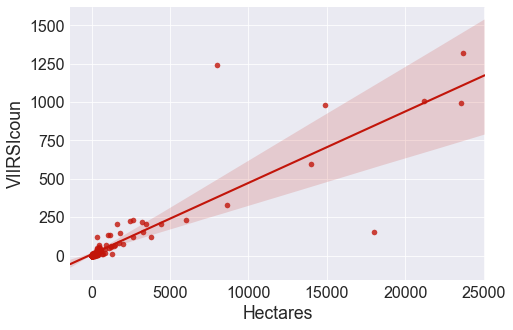

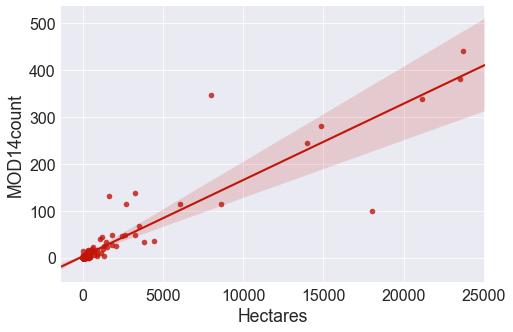

In [102]:
sns.set_context("paper", font_scale=2)
ax1 = sns.lmplot(x="Hectares", y="VIIRSIcoun", 
        size=5,
        aspect=1.5,
        data=cleanedfireperimDF);
sns.lmplot(x="Hectares", y="MOD14count", 
           data=cleanedfireperimDF,
           size=5,
           aspect=1.5,
          );

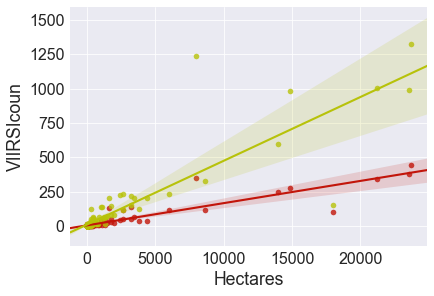

In [103]:
ax1 = sns.regplot(x="Hectares", y="MOD14count", 
           data=cleanedfireperimDF,
            line_kws={'zorder': 1}
          );sns.regplot(x="Hectares", y="VIIRSIcoun", 
           data=cleanedfireperimDF,
            line_kws={'zorder': 1},
            ax=ax1
          );

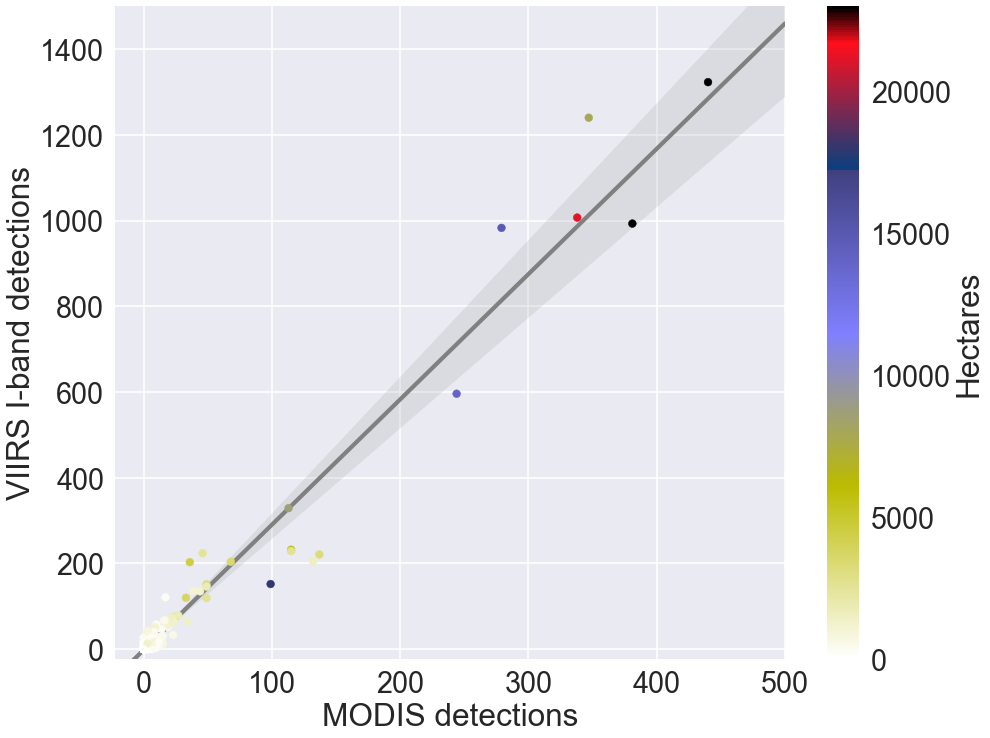

In [104]:
sns.set_context("poster", font_scale=1.8)
palette = itertools.cycle(sns.color_palette())
xlim = (-22, 500)
ylim = (-22, 1500)
ax1 = plot_frame(cleanedfireperimDF, kind='scatter', 
                                 x="MOD14count", 
                                 y="VIIRSIcoun", 
                                 xlim=xlim, 
                                 ylim=ylim, 
                                 s=60, 
                                 marker='o',
                                 c='Hectares',
                                 cmap="gist_stern_r",
                                 vmin=0, 
                                 vmax=23000,
                                 colorbar=True,
                                 legend=True,
                                 figsize=(15, 12),
                                 sharex=False,
                                 zorder=2
                                )
sns.regplot(
    x="MOD14count", 
    y="VIIRSIcoun", 
    data=cleanedfireperimDF,
    ax=ax1,
    color="grey",
    scatter=False,
    line_kws={'zorder': 1}
    )

ax1.set_xlabel('MODIS detections')
ax1.set_ylabel('VIIRS I-band detections')

f = plt.gcf()

In [105]:
gisoutdir = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/GISout/'

In [134]:
outfn = 'fig05.png'
f.savefig(os.path.join(gisoutdir, outfn), dpi=300, bbox_inches='tight')

In [135]:
outfn = 'fig05_LR.png'
f.savefig(os.path.join(gisoutdir, outfn), dpi=150, bbox_inches='tight')

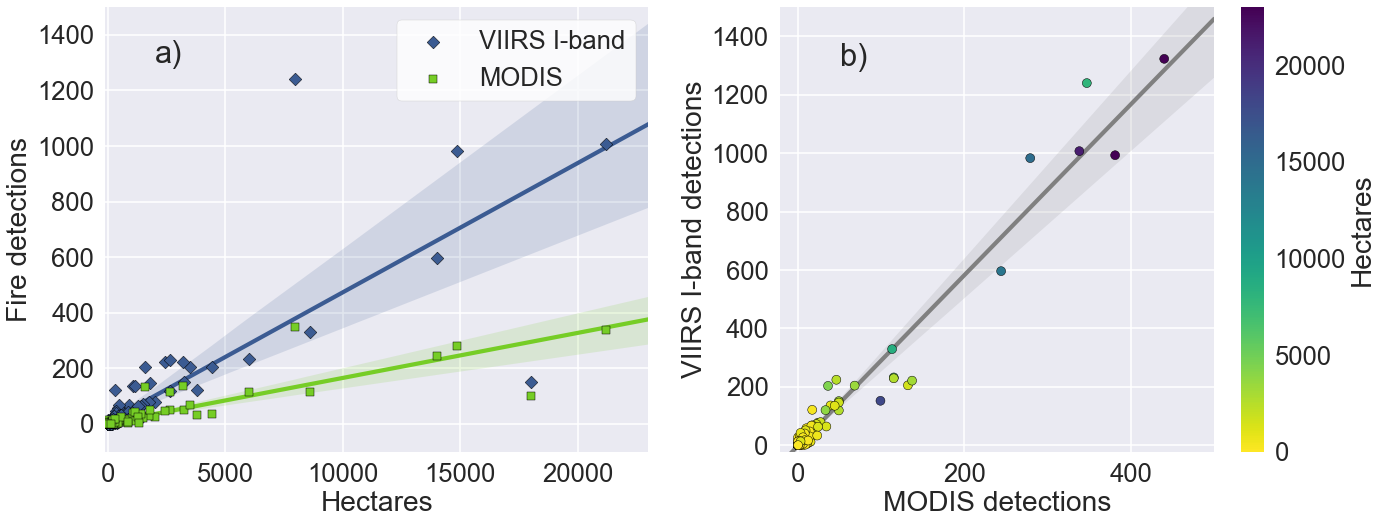

In [118]:
sns.set_context("poster", font_scale=1.6)


plotpalette = sns.xkcd_palette(['denim blue', 'apple green', ])
palette1 = itertools.cycle(plotpalette)
xlim = (-100, 23000)
ylim = (-100, 1500)

palette0 = itertools.cycle(sns.color_palette())


fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 8))
plot_frame(cleanedfireperimDF, 
        kind='scatter', x='Hectares', y="VIIRSIcoun", s=80, edgecolor='k', marker='D',
        zorder=5, ax=ax0, label="VIIRS I-band", color=next(palette1))
plot_frame(cleanedfireperimDF, 
        kind='scatter', x='Hectares', y="MOD14count", s=80,  edgecolor='k', marker='s',
        zorder=5, ax=ax0, label="MODIS", color=next(palette1))

sns.regplot(x="Hectares", y="VIIRSIcoun", 
           data=cleanedfireperimDF,
            line_kws={'zorder': 1},
            color=next(palette1),
            scatter=False,
            ax=ax0
          );
sns.regplot(x="Hectares", y="MOD14count", 
            data=cleanedfireperimDF,
            line_kws={'zorder': 1},
            color=next(palette1),
            scatter=False,
            ax=ax0
          );
leg = ax0.legend(frameon=True)
leg.get_frame().set_facecolor('white')
ax0.set_xlabel('Hectares')
ax0.set_ylabel('Fire detections')
ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax0.text(2000, 1300, 'a)')
#ax0.set_xticks([0, 25000, 50000, 75000, 100000, 125000])

# right
xlim = (-22, 500)
ylim = (-22, 1500)
plot_frame(cleanedfireperimDF, kind='scatter', 
                                 x="MOD14count", 
                                 y="VIIRSIcoun", 
                                 xlim=xlim, 
                                 ylim=ylim, 
                                 s=80, 
                                 edgecolor='k', 
                                 c='Hectares',
                                 cmap="viridis_r",
                                 vmin=0, 
                                 vmax=23000,
                                 colorbar=True,
                                 legend=True,
                                 sharex=False,
                                 zorder=2,
                                 ax=ax1
                                )
sns.regplot(
    x="MOD14count", 
    y="VIIRSIcoun", 
    data=cleanedfireperimDF,
    ax=ax1,
    color="grey",
    scatter=False,
    line_kws={'zorder': 1}
    )

ax1.set_xlabel('MODIS detections')
ax1.set_ylabel('VIIRS I-band detections')
ax1.text(50, 1300, 'b)')
plt.tight_layout()

In [119]:
outfn = 'Fig05'
fig.savefig(os.path.join(gisoutdir, outfn + '_LR.png'), dpi=150, bb_inches='tight')

In [120]:
from PIL import Image
from io import BytesIO
fig.savefig(os.path.join(gisoutdir, outfn + '.png'), dpi=300, bb_inches='tight')
png = Image.open(os.path.join(gisoutdir, outfn + '.png'))
png.save(os.path.join(gisoutdir, outfn + '.tif'))
png.close()